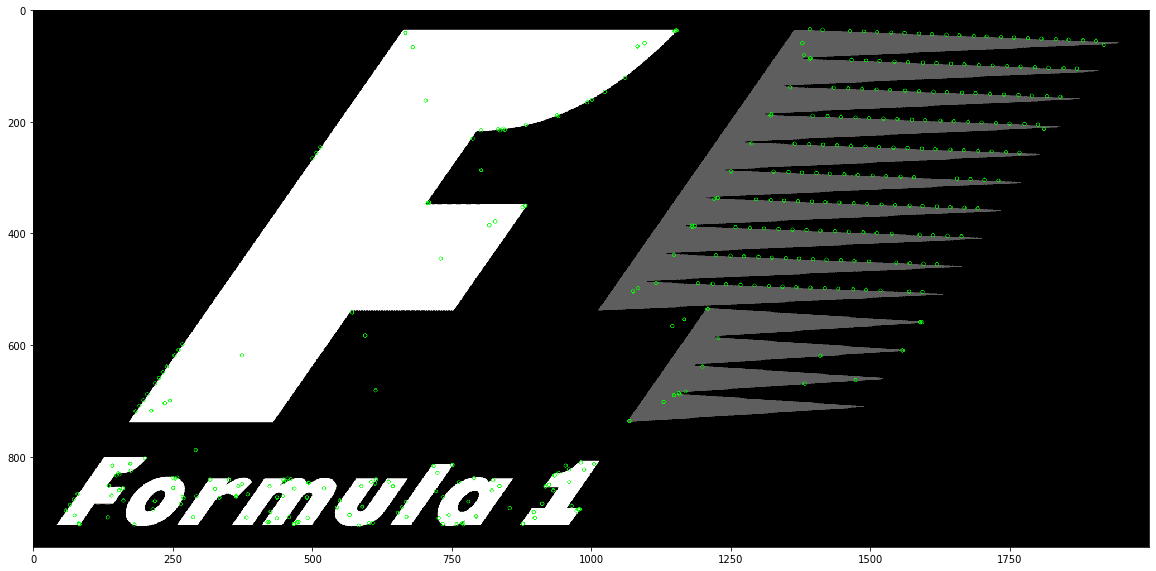

(<matplotlib.image.AxesImage at 0x1056a7f50>, None)

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import cv2

# preprocess kp/des for ad images

img1 = cv2.imread('logos/f1_old.png',0)          # queryImage
# Initiate SIFT detector
sift = cv2.xfeatures2d.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)

img1kps = cv2.drawKeypoints(img1, kp1, None, color=(0,255,0), flags=0)
plt.figure(figsize=(20,20))
plt.imshow(img1kps), plt.show()


In [3]:
FRAME_INTERVAL = 1 # 30fps?
MIN_MATCH_COUNT = 10

cap = cv2.VideoCapture('videos/08monaco.AVI')

while(True):
    for i in range(FRAME_INTERVAL):
        #skip i number of frames
        cap.grab()
        
    # Capture frame-by-frame
    ret, frame = cap.read()
    # Our operations on the frame come here
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # find the keypoints and descriptors with SIFT
    kp2, des2 = sift.detectAndCompute(gray,None)
#     img2kps = cv2.drawKeypoints(gray, kp2, None, color=(0,255,0), flags=0)
    
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
            
    if len(good)>MIN_MATCH_COUNT:
        print(len(good))
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
        matchesMask = mask.ravel().tolist()
        h,w = img1.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv2.perspectiveTransform(pts,M)
        img3 = cv2.polylines(gray,[np.int32(dst)],True,255,3, cv2.LINE_AA)
    else:
        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None
        
    draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                       singlePointColor = None,
                       matchesMask = matchesMask, # draw only inliers
                       flags = 2)
#     img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

#     # Display the resulting frame
#     cv2.imshow('frame',gray)
    
    cv2.imshow('frame',img3)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

16
182
46
14
186
184
Not enough matches are found - 5/10
Not enough matches are found - 2/10
16
Not enough matches are found - 10/10
199
27
36
37
17
25
29
18
Not enough matches are found - 10/10
161
Not enough matches are found - 7/10
25


error: OpenCV(3.4.2) /Users/travis/build/skvark/opencv-python/opencv/modules/core/src/matmul.cpp:2268: error: (-215:Assertion failed) scn + 1 == m.cols in function 'perspectiveTransform'
